# DA4 Causal Analysis: Assignment 2<br>by Mihaly Hanics


**Causal inference: To what extent does economic activity cause CO₂ emission?**

The notebook explores the causal relationship between GDP and CO₂ emission.
- GDP: produced goods and services in a country over a year
- CO2: produced CO2 in a country over a year
 
The dataset is panel data from the World Development Indicators, database of the World Bank. <br> Date goes from 1992 to 2023 (last available year).

- GDP per capita, measured in PPP USD at constant prices (NY.GDP.PCAP.PP.KD)
- CO2 emission per capita (from EN.GHG.CO2.MT.CE.AR5 (total CO2) and SP.POP.TOTL (population))
- (Potential) confounder: Oil rents (% of GDP) (NY.GDP.PETR.RT.ZS)

The analysis took inspiration from **CH 23 IMPORT DEMAND AND PRODUCTION** of the book repository [**gabors-data-analysis/da_case_studies**](https://github.com/gabors-data-analysis/da_case_studies)

## 1. Setup

Used Python version: 3.9 (3.9.17).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from linearmodels.panel import PanelOLS

#import warnings
#warnings.filterwarnings("ignore")

current_path = os.getcwd()
dirname = current_path

data_in = dirname + "/data/"
output = dirname + "/output/"

#func = dirname
#sys.path.append(func)

### 1.1 Description (of data), drop missing values

We have three variables in our data:

- GDP per capita, measured in PPP USD at constant prices (2021)
- CO2 emission per capita
- Oil rents (% of GDP)

The inference is about the causal relationship GDP and CO2 emission. Does higher GDP lead to higher CO2 emission? The first two variables are direct measures of the two quantities.

A potential confounder could be the extraction of oil - the more oil a country extracts, the more CO2 it emits, and the more GDP it produces. Typically, oil extraction is a significant part of the GDP of countries that have oil reserves, such as Saudi Arabia. This is a common cause of both GDP and CO2 emissions, so it is a confounder worth considering.

In [2]:
co2_file = "API_EN.GHG.CO2.MT.CE.AR5_DS2_en_csv_v2_3373.csv"
gdp_file = "API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_4129.csv"
pop_file = "API_SP.POP.TOTL_DS2_en_csv_v2_87.csv"
oil_file = "API_NY.GDP.PETR.RT.ZS_DS2_en_csv_v2_7383.csv"

co2 = pd.read_csv(data_in + co2_file, skiprows=4)
gdp = pd.read_csv(data_in + gdp_file, skiprows=4)
pop = pd.read_csv(data_in + pop_file, skiprows=4)
oil = pd.read_csv(data_in + oil_file, skiprows=4)

Drop any country that has missing values from 1992 to 2023 (in case of oil: from 1992 to 2021)

In [3]:
cols_extended = ['Country Name', 'Country Code', 'Indicator Name'] + [str(i) for i in range(1992, 2021+1)]
cols = cols_extended + ['2022', '2023']

missing_value_countries = list(set(list(co2[co2[cols].isnull().any(axis=1)][cols]['Country Name'])
                          + list(gdp[gdp[cols].isnull().any(axis=1)][cols]['Country Name'])
                          + list(pop[pop[cols].isnull().any(axis=1)][cols]['Country Name'])
                          + list(oil[oil[cols_extended].isnull().any(axis=1)][cols_extended]['Country Name'])))

print(f'{len(missing_value_countries)} number of missing value countries: {missing_value_countries}')

co2 = co2[~co2['Country Name'].isin(missing_value_countries)]
gdp = gdp[~gdp['Country Name'].isin(missing_value_countries)]
pop = pop[~pop['Country Name'].isin(missing_value_countries)]
oil = oil[~oil['Country Name'].isin(missing_value_countries)]

66 number of missing value countries: ['Timor-Leste', 'Sao Tome and Principe', 'Curacao', 'Liberia', 'Cuba', 'Virgin Islands (U.S.)', 'Equatorial Guinea', 'Nauru', 'Monaco', 'Tonga', 'St. Martin (French part)', 'Moldova', 'Azerbaijan', 'South Sudan', 'American Samoa', 'West Bank and Gaza', 'Iran, Islamic Rep.', 'Middle East & North Africa (IDA & IBRD countries)', 'Isle of Man', 'Channel Islands', 'Marshall Islands', 'Lebanon', 'Yemen, Rep.', 'Benin', 'Bhutan', 'Eritrea', 'Gibraltar', 'Cambodia', 'Syrian Arab Republic', 'Liechtenstein', 'Bosnia and Herzegovina', 'French Polynesia', 'Iraq', 'Slovenia', 'Djibouti', 'Faroe Islands', 'Croatia', 'Israel', 'Not classified', 'Sweden', 'Greenland', 'Turkmenistan', 'Lithuania', 'San Marino', 'Andorra', 'Tuvalu', 'Venezuela, RB', 'Kosovo', 'Estonia', 'Micronesia, Fed. Sts.', 'New Caledonia', 'Montenegro', 'Afghanistan', 'Sint Maarten (Dutch part)', 'Latvia', 'Somalia', 'Cayman Islands', 'British Virgin Islands', 'Kuwait', 'Serbia', 'Northern Mari

Let's first create a CO2 per capita table, then combine the collected data:

In [4]:
def co2_per_capita(co2, pop_df):
    df = pd.merge(co2, pop_df, on=["Country Name", "Country Code"])
    df['Indicator Name'] = "CO2 emissions (MtCO2e) per capita"
    for i in range(1960, 2023+1):
        col_a = str(i) + "_x"
        col_b = str(i) + "_y"
        df[str(i)] = df[col_a] / df[col_b]
        df = df.drop(columns=[col_a, col_b])
    df = df.drop(columns=["Indicator Code_x", "Indicator Code_y", "Indicator Name_x", "Indicator Name_y"])
    return df
    
def combine_dfs(dfs=[], cols=['Country Name', 'Country Code', 'Indicator Name']):
    df = dfs[0]
    for i in range(1, len(dfs)):
        df = df.append(dfs[i], ignore_index=True)

    columns = [x for x in cols if x in df.columns] #Sort columns based on the index in cols
    df = df[columns]
    df = df.sort_values(by=[cols[0]])
    df = df.reset_index(drop=True)
    return df

co2_pc = co2_per_capita(co2, pop)
cols = ['Country Name', 'Country Code', 'Indicator Name'] + [str(i) for i in range(1960, 2023+1)]
data_extended = combine_dfs([gdp, co2_pc, oil], cols)

A look into the data:

In [5]:
data_extended[:10]

,Country Name,Country Code,Indicator Name,1960,1961,1962,1963,1964,1965,1966,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Africa Eastern and Southern,AFE,"GDP per capita, PPP (constant 2021 internation...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.052852e+03,4.076021e+03,4.074982e+03,4.085879e+03,4.088891e+03,4.073881e+03,3.861111e+03,3.934287e+03,3.974803e+03,3.967861e+03
1,Africa Eastern and Southern,AFE,CO2 emissions (MtCO2e) per capita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.075572e-06,1.024284e-06,1.008289e-06,9.966379e-07,9.818115e-07,9.683259e-07,8.323929e-07,8.503747e-07,8.040671e-07,7.726350e-07
2,Africa Eastern and Southern,AFE,Oil rents (% of GDP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.858704e+00,1.565946e+00,1.387176e+00,2.064717e+00,2.740083e+00,2.223498e+00,1.126503e+00,2.040738e+00,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (constant 2021 internation...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.816917e+03,4.817801e+03,4.713515e+03,4.709645e+03,4.730823e+03,4.774413e+03,4.622731e+03,4.698927e+03,4.767383e+03,4.814611e+03
4,Africa Western and Central,AFW,CO2 emissions (MtCO2e) per capita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.134692e-07,4.995869e-07,5.063234e-07,4.950605e-07,5.097129e-07,5.188905e-07,4.971592e-07,5.127488e-07,5.054622e-07,4.822173e-07
5,Africa Western and Central,AFW,Oil rents (% of GDP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.642740e+00,2.666028e+00,2.435413e+00,4.602161e+00,6.534543e+00,5.690815e+00,2.895055e+00,5.221742e+00,NaN,NaN
6,Albania,ALB,Oil rents (% of GDP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.122076e+00,1.452606e+00,8.844107e-01,1.126142e+00,1.469834e+00,1.424371e+00,5.822257e-01,1.042184e+00,NaN,NaN
7,Albania,ALB,CO2 emissions (MtCO2e) per capita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.763799e-06,1.688303e-06,1.575153e-06,1.858911e-06,1.850978e-06,1.735518e-06,1.607133e-06,1.792283e-06,1.659293e-06,1.672195e-06
8,Albania,ALB,"GDP per capita, PPP (constant 2021 internation...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.278875e+04,1.311062e+04,1.356691e+04,1.409576e+04,1.469854e+04,1.506575e+04,1.465040e+04,1.611314e+04,1.709748e+04,1.797580e+04
9,Algeria,DZA,Oil rents (% of GDP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.931673e+01,1.174590e+01,1.002622e+01,1.215657e+01,1.594281e+01,1.414210e+01,9.038414e+00,1.446157e+01,NaN,NaN


Let's see the initial descriptions of the different datasets:

In [6]:
cols = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
co2_pc[cols].describe()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,4.645043e-06,4.622448e-06,4.629913e-06,4.608142e-06,4.555090e-06,4.479908e-06,4.453546e-06,4.447594e-06,4.441256e-06,4.442525e-06,4.164570e-06
std,6.016938e-06,6.222768e-06,6.212768e-06,6.156842e-06,5.993952e-06,5.782209e-06,5.579026e-06,5.462488e-06,5.412995e-06,5.412832e-06,5.163994e-06
min,3.425606e-08,4.310567e-08,4.012500e-08,3.246152e-08,3.506243e-08,3.908548e-08,3.203924e-08,3.593337e-08,3.445620e-08,3.609029e-08,3.602667e-08
25%,7.653034e-07,7.522586e-07,7.783112e-07,7.610647e-07,8.361049e-07,8.178375e-07,8.035335e-07,8.637989e-07,8.625825e-07,8.502324e-07,7.755752e-07
50%,2.504109e-06,2.410097e-06,2.546545e-06,2.634023e-06,2.704195e-06,2.684750e-06,2.689432e-06,2.604435e-06,2.654447e-06,2.742954e-06,2.413174e-06
75%,6.632793e-06,6.657590e-06,6.573009e-06,6.497223e-06,6.428696e-06,6.023904e-06,6.155335e-06,6.057960e-06,6.234252e-06,6.173557e-06,5.727179e-06
max,4.466086e-05,5.119645e-05,5.359839e-05,5.329321e-05,5.147627e-05,4.865870e-05,4.604299e-05,4.482041e-05,4.452016e-05,4.459625e-05,4.126149e-05


In [7]:
gdp[cols].describe()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,21695.420473,22249.905015,22488.798991,22734.739618,22926.540466,23061.994581,23330.977441,23894.655678,24402.481422,24703.904355,22972.192849
std,24247.741231,25344.627566,25405.305582,25573.331133,25130.270864,24380.567371,24462.058913,25017.139205,25448.436734,25500.762099,23487.997471
min,947.621417,951.188460,958.657403,970.375392,977.765840,918.557193,897.459046,880.993440,868.555508,855.732720,833.920257
25%,4687.682424,4964.374298,4978.923142,5335.976844,5448.586353,5466.263777,5644.805908,5808.850382,5881.421935,6039.421140,5586.896959
50%,12929.581650,13054.083734,13223.138772,13806.852438,14233.227713,14552.427761,14983.675685,15394.209739,15926.646540,16239.236899,15288.270054
75%,27974.386644,29136.758205,29038.949838,29764.413819,30747.579923,31446.612193,31856.834097,33020.879712,34518.467930,34912.416658,31379.146447
max,130620.266278,155185.383338,164065.103441,174339.077325,162582.374111,129293.707435,132836.085831,133500.278527,139787.776691,133549.188038,128256.560341


In [8]:
oil[cols].describe()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.706531,4.504819,4.107008,3.580772,3.016705,1.532212,1.352274,1.878396,2.563152,2.263555,1.327941
std,8.161467,9.083384,8.855007,7.694143,6.366948,3.576541,3.276613,4.457978,5.953824,5.492556,3.285784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000398,0.000294,0.001282,0.000000,0.000087,0.000000,0.000000,0.000000,0.000000
50%,0.283614,0.416584,0.390286,0.372215,0.302991,0.086463,0.086505,0.134791,0.175532,0.142102,0.091460
75%,3.457157,4.601418,3.962286,3.447797,3.040879,1.294124,0.940993,1.405364,2.025350,1.598266,0.884449
max,54.526430,49.161219,57.630094,45.801614,40.321969,23.956799,20.005177,25.022777,38.248716,35.851799,22.408413


We see for example a decrease in maximum and average oil rent percentages over the previous decade.

The data contains 200 countries after removals of countries with missing values, this is reasonable.

### 1.2 Feature engineering

- Filter to columns: 1992-2023, and in the case of oil rents, 1992-2021
- Switch to logs if needed
- Drop missing values

In [9]:
cols_extended = ['Country Name', 'Country Code', 'Indicator Name'] + [str(i) for i in range(1992, 2021+1)]
cols = cols_extended + ['2022', '2023']

data = data_extended.copy()
data_extended = data_extended[cols_extended]
data = data[cols]
data = data[data['Indicator Name'] != 'Oil rents (% of GDP)'].reset_index(drop=True)
data


,Country Name,Country Code,Indicator Name,1992,1993,1994,1995,1996,1997,1998,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Africa Eastern and Southern,AFE,"GDP per capita, PPP (constant 2021 internation...",3.135101e+03,3.023989e+03,2.993630e+03,3.048085e+03,3.133178e+03,3.177467e+03,3.155074e+03,...,4.052852e+03,4.076021e+03,4.074982e+03,4.085879e+03,4.088891e+03,4.073881e+03,3.861111e+03,3.934287e+03,3.974803e+03,3.967861e+03
1,Africa Eastern and Southern,AFE,CO2 emissions (MtCO2e) per capita,1.107219e-06,1.077264e-06,1.072943e-06,1.100875e-06,1.112196e-06,1.128229e-06,1.119558e-06,...,1.075572e-06,1.024284e-06,1.008289e-06,9.966379e-07,9.818115e-07,9.683259e-07,8.323929e-07,8.503747e-07,8.040671e-07,7.726350e-07
2,Africa Western and Central,AFW,"GDP per capita, PPP (constant 2021 internation...",3.228264e+03,3.106502e+03,3.022457e+03,3.006397e+03,3.063322e+03,3.115781e+03,3.144168e+03,...,4.816917e+03,4.817801e+03,4.713515e+03,4.709645e+03,4.730823e+03,4.774413e+03,4.622731e+03,4.698927e+03,4.767383e+03,4.814611e+03
3,Africa Western and Central,AFW,CO2 emissions (MtCO2e) per capita,5.282900e-07,5.063104e-07,4.776365e-07,5.071833e-07,5.711955e-07,5.534882e-07,5.187281e-07,...,5.134692e-07,4.995869e-07,5.063234e-07,4.950605e-07,5.097129e-07,5.188905e-07,4.971592e-07,5.127488e-07,5.054622e-07,4.822173e-07
4,Albania,ALB,CO2 emissions (MtCO2e) per capita,7.277400e-07,6.887209e-07,7.308102e-07,6.493539e-07,6.486359e-07,5.020200e-07,6.120127e-07,...,1.763799e-06,1.688303e-06,1.575153e-06,1.858911e-06,1.850978e-06,1.735518e-06,1.607133e-06,1.792283e-06,1.659293e-06,1.672195e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,World,WLD,CO2 emissions (MtCO2e) per capita,4.146288e-06,4.097715e-06,4.076070e-06,4.127833e-06,4.146839e-06,4.163203e-06,4.130153e-06,...,4.953523e-06,4.878130e-06,4.838088e-06,4.865632e-06,4.934006e-06,4.894813e-06,4.602045e-06,4.812540e-06,4.786823e-06,4.840553e-06
396,Zambia,ZMB,CO2 emissions (MtCO2e) per capita,3.836520e-07,3.396975e-07,2.782562e-07,2.682180e-07,2.202008e-07,2.704864e-07,2.470153e-07,...,3.151746e-07,3.244083e-07,3.430800e-07,4.057720e-07,4.482248e-07,3.795377e-07,3.923105e-07,3.960802e-07,3.873877e-07,3.888735e-07
397,Zambia,ZMB,"GDP per capita, PPP (constant 2021 internation...",2.268498e+03,2.365630e+03,2.110583e+03,2.119956e+03,2.197196e+03,2.223457e+03,2.157573e+03,...,3.585577e+03,3.576925e+03,3.598172e+03,3.612506e+03,3.646960e+03,3.591564e+03,3.391595e+03,3.503035e+03,3.585124e+03,3.673484e+03
398,Zimbabwe,ZWE,"GDP per capita, PPP (constant 2021 internation...",3.649892e+03,3.634750e+03,3.965731e+03,3.935280e+03,4.271480e+03,4.304406e+03,4.342858e+03,...,3.360552e+03,3.382923e+03,3.366344e+03,3.453510e+03,3.572984e+03,3.294806e+03,2.987270e+03,3.184785e+03,3.323122e+03,3.442251e+03


#### 1.2.1 Distributions

Let's see if we need to use logs for the variables:

In [10]:
def plot_indicator_distribution(data, indicator_name, year=2010, bins = 20):
    data_values = data[data['Indicator Name'] == indicator_name]
    data_values = data_values.dropna(subset=[str(year)])
    data_values = data_values[str(year)].values
    data_values_log = np.log(data_values+10**-20)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    axes[0].hist(data_values, bins=bins)
    axes[0].set_xlabel(indicator_name)
    axes[0].set_ylabel('Number of countries')
    axes[0].set_title('Distribution of ' + indicator_name + ' (' + str(year) + ')')
    axes[0].grid(True)

    axes[1].hist(data_values_log, bins=bins)
    axes[1].set_xlabel('Log ' + indicator_name)
    axes[1].set_ylabel('Number of countries')
    axes[1].set_title('Distribution of log ' + indicator_name + ' (' + str(year) + ')')
    axes[1].grid(True)
    return axes

##### CO2 per capita:

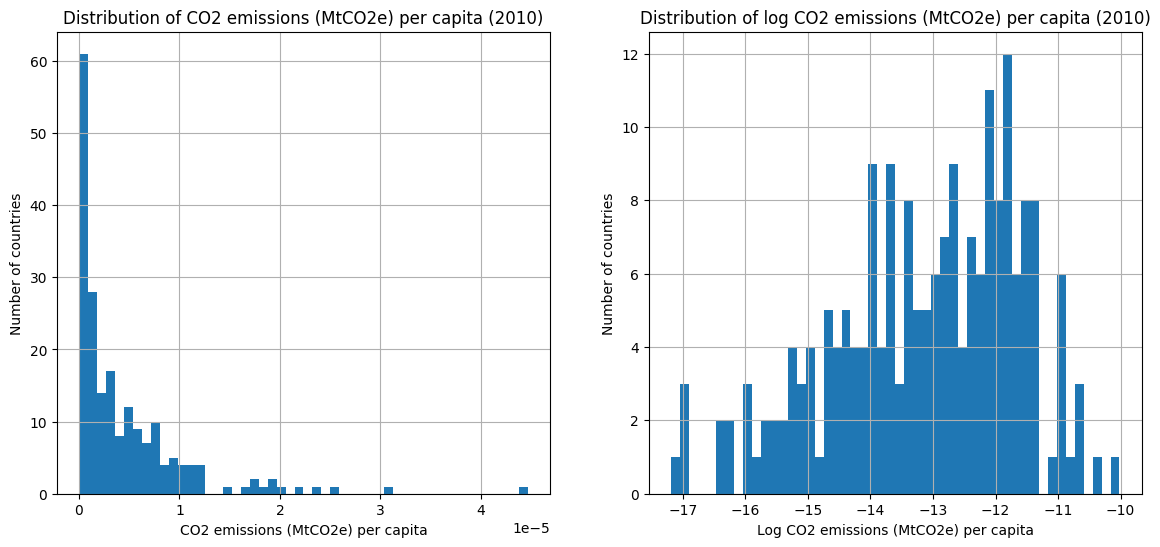

In [11]:
indicator_name = 'CO2 emissions (MtCO2e) per capita'
axes = plot_indicator_distribution(data, indicator_name, year=2010, bins = 50)

CO2 per capita: Yes, we should use log values. The distribution is very uneven, the distance between non-empty bins is increasing.

##### GDP per capita:

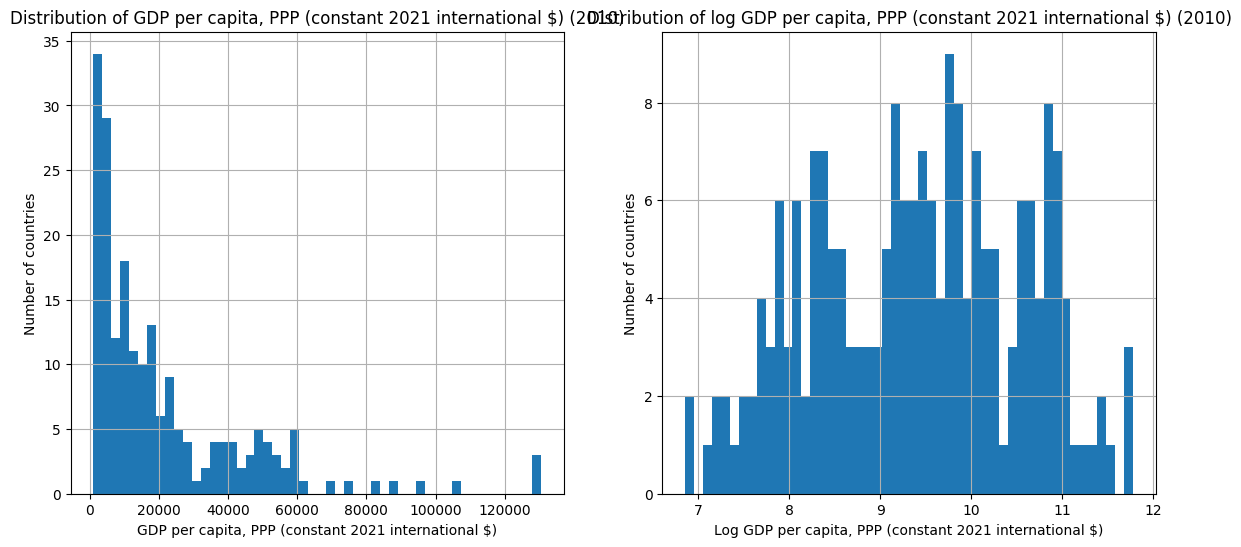

In [12]:
indicator_name = 'GDP per capita, PPP (constant 2021 international $)'
axes = plot_indicator_distribution(data_extended, indicator_name, year=2010, bins = 50)

GDP per capita: Yes, we should use log values. The distribution is very uneven, the distance between non-empty bins is increasing.

##### Oil rents (% of GDP):

Let's see the initial plot (which we will see, is not enough):

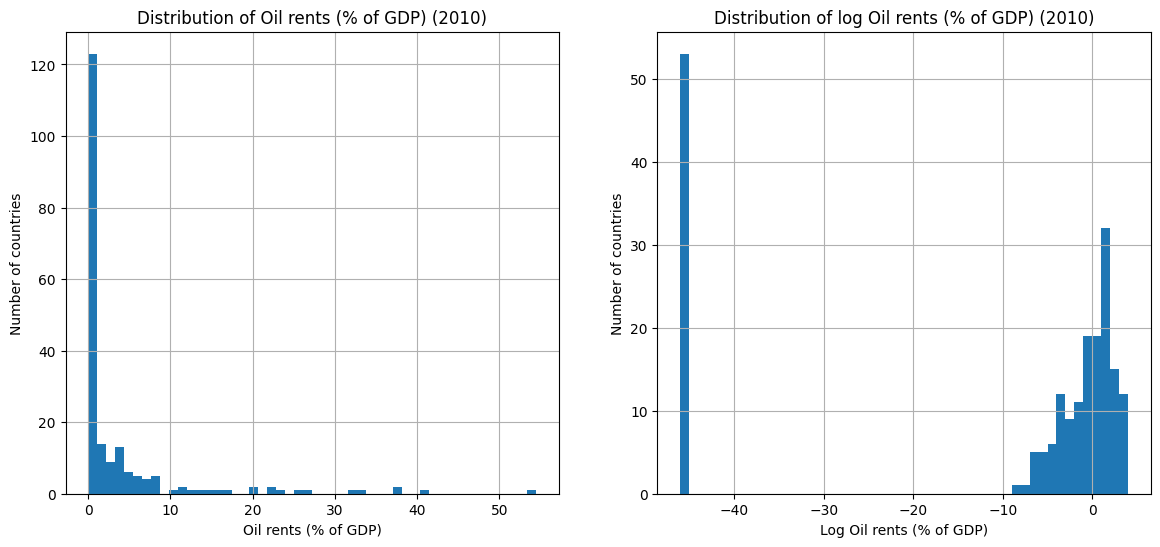

In [13]:
indicator_name = 'Oil rents (% of GDP)'
axes = plot_indicator_distribution(data_extended, indicator_name, year=2010, bins = 50)

There are many 0.0% values, so probably it's better to check only for non-zero values:

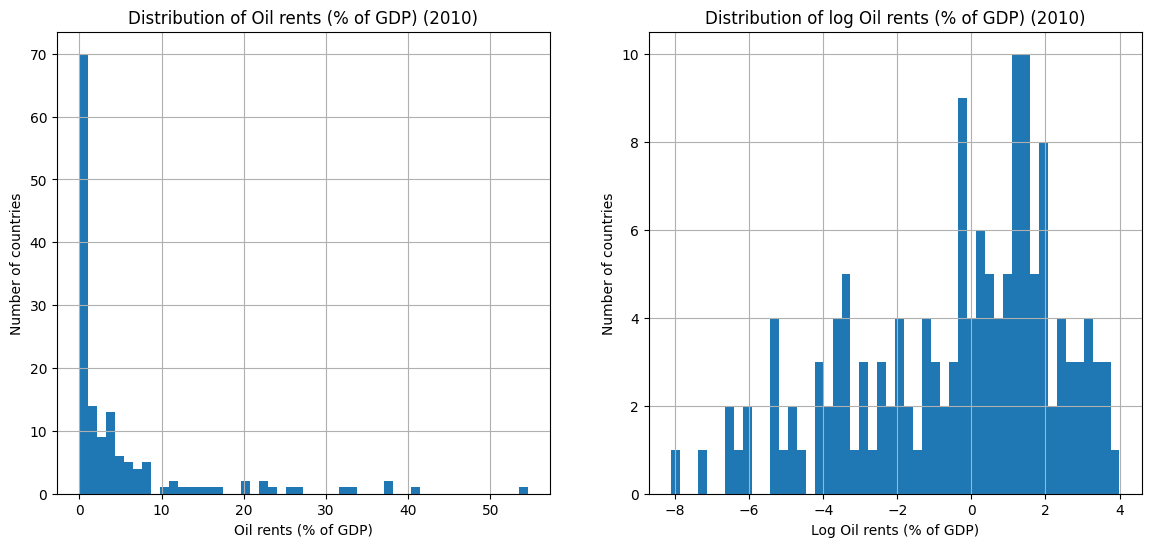

In [14]:
df = data_extended[(data_extended['Indicator Name'] == 'Oil rents (% of GDP)')&(data_extended['2010'] > 0)]
axes = plot_indicator_distribution(df, indicator_name, year=2010, bins = 50)

Oil rents: Yes, we should use log values. Even in this case, the log values are more evenly distributed.

#### 1.2.2 Log values

In [15]:
cols_extended = [str(i) for i in range(1992, 2021+1)]
cols = cols_extended + ['2022', '2023']

for col in cols:
    data[col] = np.log(data[col] + 10**-10) #avoid log(0)

for col in cols_extended:
    data_extended[col] = np.log(data_extended[col] + 10**-10)

data['Indicator Name'] = data['Indicator Name'].apply(lambda x: "log " + x)
data_extended['Indicator Name'] = data_extended['Indicator Name'].apply(lambda x: "log " + x)

## 2. Models

 1. Cross-section OLS for the year 2005
 2. Cross-section OLS for the last year
 3. First difference model, with time trend, no lags 
 4. First difference model, with time trend, 2 year lags
 5. First difference model, with time trend, 6 year lags
 6. Fixed effects model with time and country fixed effects

Let's prepare the data into easier format for the models:

In [16]:
data_long = data.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name'], 
                      var_name='Year', value_name='Value')
data_extended_long = data_extended.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name'],
                                        var_name='Year', value_name='Value')

data_country = data_long.pivot_table(index=['Country Name', 'Country Code', 'Year'], 
                                     columns='Indicator Name', values='Value').reset_index().rename(
                                         columns={'log CO2 emissions (MtCO2e) per capita': 'log_co2_pc',
                                                  'log GDP per capita, PPP (constant 2021 international $)': 'log_gdp_pc',
                                                  }).sort_values(by=['Country Name', 'Year']).reset_index(drop=True)
data_extended_country = data_extended_long.pivot_table(index=['Country Name', 'Country Code', 'Year'],
                                                       columns='Indicator Name', values='Value').reset_index().rename(
                                                          columns={'log CO2 emissions (MtCO2e) per capita': 'log_co2_pc',
                                                                   'log GDP per capita, PPP (constant 2021 international $)': 'log_gdp_pc',
                                                                   'log Oil rents (% of GDP)': 'log_oil_rent',
                                                                   }).sort_values(by=['Country Name', 'Year']).reset_index(drop=True)

First differences: since all rows are sorted by Year (after country), grouping by country and taking the difference between consecutive rows of one variable gives the first difference

In [17]:
data_country["d_log_gdp_pc"] = data_country.groupby("Country Code")["log_gdp_pc"].diff()
data_country["d_log_co2_pc"] = data_country.groupby("Country Code")["log_co2_pc"].diff()
data_country['Year'] = data_country['Year'].astype(int)
data_country["time_trend"] = data_country["Year"] - data_country["Year"].min()
data_country["d_time_trend"] = 1 #Every diff is 1
data_country["d_log_gdp_pc_lag1"] = data_country.groupby("Country Code")["d_log_gdp_pc"].shift(1)
data_country["d_log_gdp_pc_lag2"] = data_country.groupby("Country Code")["d_log_gdp_pc"].shift(2)
data_country["d_log_gdp_pc_lag3"] = data_country.groupby("Country Code")["d_log_gdp_pc"].shift(3)
data_country["d_log_gdp_pc_lag4"] = data_country.groupby("Country Code")["d_log_gdp_pc"].shift(4)
data_country["d_log_gdp_pc_lag5"] = data_country.groupby("Country Code")["d_log_gdp_pc"].shift(5)
data_country["d_log_gdp_pc_lag6"] = data_country.groupby("Country Code")["d_log_gdp_pc"].shift(6)

data_extended_country["d_log_gdp_pc"] = data_extended_country.groupby("Country Code")["log_gdp_pc"].diff()
data_extended_country["d_log_co2_pc"] = data_extended_country.groupby("Country Code")["log_co2_pc"].diff()
data_extended_country["d_log_oil_rent"] = data_extended_country.groupby("Country Code")["log_oil_rent"].diff()
data_extended_country['Year'] = data_extended_country['Year'].astype(int)
data_extended_country["time_trend"] = data_extended_country["Year"] - data_extended_country["Year"].min()
data_extended_country["d_time_trend"] = 1
data_extended_country["d_log_gdp_pc_lag1"] = data_extended_country.groupby("Country Code")["d_log_gdp_pc"].shift(1)
data_extended_country["d_log_gdp_pc_lag2"] = data_extended_country.groupby("Country Code")["d_log_gdp_pc"].shift(2)
data_extended_country["d_log_gdp_pc_lag3"] = data_extended_country.groupby("Country Code")["d_log_gdp_pc"].shift(3)
data_extended_country["d_log_gdp_pc_lag4"] = data_extended_country.groupby("Country Code")["d_log_gdp_pc"].shift(4)
data_extended_country["d_log_gdp_pc_lag5"] = data_extended_country.groupby("Country Code")["d_log_gdp_pc"].shift(5)
data_extended_country["d_log_gdp_pc_lag6"] = data_extended_country.groupby("Country Code")["d_log_gdp_pc"].shift(6)

### 2.1 Cross-section OLS for the year 2005

In [19]:
y = 'log_co2_pc'
x = 'log_gdp_pc'
fit = smf.ols(f'{y} ~ {x}', data=data_country[data_country['Year']==2005]).fit()

print("Beta1:", fit.params['log_gdp_pc'], " with p-value:", fit.pvalues['log_gdp_pc'])
fit.summary()

Beta1: 1.1923719754756672  with p-value: 4.114372584792816e-73


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_co2_pc   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     838.8
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           4.11e-73
Time:                        03:13:10   Log-Likelihood:                -207.57
No. Observations:                 200   AIC:                             419.1
Df Residuals:                     198   BIC:                             425.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.2662      0.385    -63.021      0.000     -25.025     -23.507
log_gdp_pc     1.1924      0.041     28.962      0.000       1.111       1.274
==============================================================================
Omnibus:                        2.742   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.346
Skew:                          -0.208   Prob(JB):                        0.309
Kurtosis:                       3.330   Cond. No.                         75.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit summary:

The predicted $\beta_1$ coefficient is 1.1924 (an increase of 1 unit in the log GDP per capita leads to a 1.1924 increase in the log CO2 per capita), which, with very low p-value, is significant. Therefore, this would simply suggest that (in this year), there is a positive relationship (which we hope to be causal) between GDP and CO2 emissions.

The R-squared value is above 0.8, which is quite high - let's see how the fit looks like:

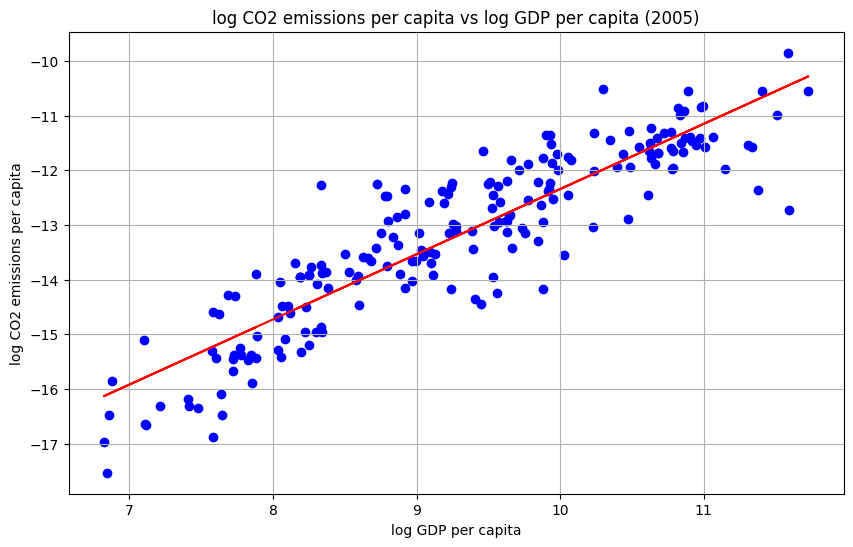

In [23]:
data_2005 = data_country[data_country['Year']==2005]
plt.figure(figsize=(10, 6))
plt.scatter(data_2005[x], data_2005[y], color='blue')
plt.plot(data_2005[x], fit.fittedvalues, color='red')
plt.xlabel('log GDP per capita')
plt.ylabel('log CO2 emissions per capita')
plt.title('log CO2 emissions per capita vs log GDP per capita (2005)')
plt.grid(True)


A very strong linear relationship is visible, as expected based on the high R-squared value.

#### 2.1.1 With confounder: Oil rents

We expect that adding the confounder will decrease the coefficient of GDP, as the confounder is a common cause of both GDP and CO2 emissions. We can sign the effect as negative: it should decrease the GDP-CO2 relationship.

In [24]:
#now let's use z=oil rent as an instrument as confounding variable
z = 'log_oil_rent'
fit = smf.ols(f'{y} ~ {x} + {z}', data=data_extended_country[data_extended_country['Year']==2005]).fit()
print("Beta1:", fit.params['log_gdp_pc'], " with p-value:", fit.pvalues['log_gdp_pc'])
print("Beta2:", fit.params['log_oil_rent'], " with p-value:", fit.pvalues['log_oil_rent'])
fit.summary()

Beta1: 1.1340951811142317  with p-value: 4.7664053729925484e-76
Beta2: 0.030306710231904052  with p-value: 6.0616020472502395e-12


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_co2_pc   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     557.7
Date:                H, 17 febr. 2025   Prob (F-statistic):           7.53e-82
Time:                        03:15:38   Log-Likelihood:                -183.50
No. Observations:                 200   AIC:                             373.0
Df Residuals:                     197   BIC:                             382.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -23.5175      0.357    -65.841      0.000     -24.222     -22.813
log_gdp_pc       1.1341      0.037     30.284      0.000       1.060       1.208
log_oil_rent     0.0303      0.004      7.323      0.000       0.022       0.038
==============================================================================
Omnibus:                        2.293   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                2.214
Skew:                          -0.029   Prob(JB):                        0.331
Kurtosis:                       3.512   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit summary:

While the $\beta_1$ coefficient is still significant, it decreased by 0.06 compared to the previous model. This is as expected (as `z` is positively correlated with both, therefore adding it to the OLS can reduce the impact of `x`) and suggests that indeed, the confounder has an effect on the relationship between GDP and CO2 emissions, and is worth considering. The coefficient of the confounder $\beta_2=0.03$ is also significant.

### 2.2 Cross-section OLS for the last year

In [25]:
fit = smf.ols(f'{y} ~ {x}', data=data_country[data_country['Year']==2023]).fit()

print("Beta1:", fit.params['log_gdp_pc'], " with p-value:", fit.pvalues['log_gdp_pc'])
fit.summary()

Beta1: 1.0629390888474202  with p-value: 3.91572757009932e-74


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_co2_pc   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     863.7
Date:                H, 17 febr. 2025   Prob (F-statistic):           3.92e-74
Time:                        03:15:38   Log-Likelihood:                -174.02
No. Observations:                 200   AIC:                             352.0
Df Residuals:                     198   BIC:                             358.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.2778      0.350    -66.512      0.000     -23.968     -22.588
log_gdp_pc     1.0629      0.036     29.389      0.000       0.992       1.134
==============================================================================
Omnibus:                        0.373   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.830   Jarque-Bera (JB):                0.522
Skew:                           0.029   Prob(JB):                        0.770
Kurtosis:                       2.757   Cond. No.                         83.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit summary:

While the $\beta_1$ coefficient is still very significant, it is now only 1.063, which is lower than previous models. This suggests that there is a decrease in the increase in CO2 emissions by GDP increase, compared to 2005 - it might suggest this as a trend. The R-squared value is still very high.

### 2.3 First difference model, with time trend, no lags

We can reduce some of the confounding effects by using a first difference model: instead of $y = \beta_0 + \beta_1 x + \beta_2 timetrend + \epsilon $, we use $\Delta y = \beta_1 \Delta x + \beta_2 (1) + \Delta \epsilon $, time invariant effects fall out. Because all instances are differenced with the previous year, the delta time is always 1.

We can include the constant 1 (delta time) to account for the linear component of the time trend.

In [26]:
data_country.dropna(subset=['d_log_gdp_pc'])

Indicator Name,Country Name,Country Code,Year,log_co2_pc,log_gdp_pc,d_log_gdp_pc,d_log_co2_pc,time_trend,d_time_trend,d_log_gdp_pc_lag1,d_log_gdp_pc_lag2,d_log_gdp_pc_lag3,d_log_gdp_pc_lag4,d_log_gdp_pc_lag5,d_log_gdp_pc_lag6
1,Africa Eastern and Southern,AFE,1993,-13.740994,8.014332,-0.036085,-0.027425,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,Africa Eastern and Southern,AFE,1994,-13.745012,8.004242,-0.010090,-0.004018,2,1,-0.036085,NaN,NaN,NaN,NaN,NaN
3,Africa Eastern and Southern,AFE,1995,-13.719315,8.022269,0.018027,0.025697,3,1,-0.010090,-0.036085,NaN,NaN,NaN,NaN
4,Africa Eastern and Southern,AFE,1996,-13.709084,8.049803,0.027534,0.010230,4,1,0.018027,-0.010090,-0.036085,NaN,NaN,NaN
5,Africa Eastern and Southern,AFE,1997,-13.694773,8.063840,0.014037,0.014312,5,1,0.027534,0.018027,-0.010090,-0.036085,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,Zimbabwe,ZWE,2019,-14.128194,8.100103,-0.081054,-0.109618,27,1,0.034010,0.025564,-0.004913,0.006635,0.001019,0.017388
6396,Zimbabwe,ZWE,2020,-14.352709,8.002115,-0.097987,-0.224515,28,1,-0.081054,0.034010,0.025564,-0.004913,0.006635,0.001019
6397,Zimbabwe,ZWE,2021,-14.212146,8.066140,0.064025,0.140563,29,1,-0.097987,-0.081054,0.034010,0.025564,-0.004913,0.006635
6398,Zimbabwe,ZWE,2022,-14.197733,8.108660,0.042520,0.014412,30,1,0.064025,-0.097987,-0.081054,0.034010,0.025564,-0.004913


In [27]:
#df_subset = data_country[['Country Name', 'Country Code', 'Year', 'd_log_gdp_pc', 'd_log_co2_pc', 'time_trend', 'd_time_trend']]
dy = 'd_log_co2_pc'
dx = 'd_log_gdp_pc'
dt = 'd_time_trend'
fit = smf.ols(f"{dy} ~ {dx} + {dt}", data=data_country.dropna(subset=[dx])).fit()
print("Beta1:", fit.params['d_log_gdp_pc'], " with p-value:", fit.pvalues['d_log_gdp_pc'])
fit.summary()

Beta1: 0.5635243472761852  with p-value: 1.0804496871324644e-120


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           d_log_co2_pc   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     285.3
Date:                H, 17 febr. 2025   Prob (F-statistic):          2.88e-119
Time:                        03:15:38   Log-Likelihood:                 6112.1
No. Observations:                6200   AIC:                        -1.222e+04
Df Residuals:                    6197   BIC:                        -1.220e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.873e+09    3.8e+10      0.076      0.940   -7.16e+10    7.73e+10
d_log_gdp_pc     0.5635      0.024     23.885      0.000       0.517       0.610
d_time_trend -2.873e+09    3.8e+10     -0.076      0.940   -7.73e+10    7.16e+10
==============================================================================
Omnibus:                     1988.957   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83380.667
Skew:                           0.817   Prob(JB):                         0.00
Kurtosis:                      20.891   Cond. No.                     6.62e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.83e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can observe three things:

- Firstly, the coefficient of GDP is still significant but has decreased. It is 0.564, which is almost half of the estimates of the previous models. This suggests that the first difference model can reduce the effect of confounding variables- The relationship between GDP and CO2 emissions is still significant, but the (unit) increase is only 0.564.
- Secondly, the linear component of the time trend is not significant, which suggests that there is no significant global trend in the data.
- Third: The R-squared value is low, only 8.4%. This is expected and shows that we did things right: the first difference model only looks at relativities, so the variance is now not compared to the absolute values, but the increases in the values - and we see that not much of the increase in CO2 emissions is explained by the increase in GDP.

### 2.4 First difference model, with time trend, 2 year lags

We include the previous 2 years' GDP differences as lags. This can account for the fact that the effect of GDP on CO2 emissions might take time, for example. 

In [28]:
z1 = 'd_log_gdp_pc_lag1'
z2 = 'd_log_gdp_pc_lag2'
fit = smf.ols(f"{dy} ~ {dx} + {dt} + {z1} + {z2}",
              data=data_country.dropna(subset=[dx, z1, z2])).fit()
print("Beta1:", fit.params['d_log_gdp_pc'], " with p-value:", fit.pvalues['d_log_gdp_pc'])
fit.summary()

Beta1: 0.5316462018213811  with p-value: 1.2228976296170111e-98


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           d_log_co2_pc   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     121.7
Date:                H, 17 febr. 2025   Prob (F-statistic):          6.98e-100
Time:                        03:15:38   Log-Likelihood:                 5915.2
No. Observations:                5800   AIC:                        -1.182e+04
Df Residuals:                    5795   BIC:                        -1.179e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -7.179e+09   3.56e+10     -0.202      0.840    -7.7e+10    6.26e+10
d_log_gdp_pc          0.5316      0.025     21.491      0.000       0.483       0.580
d_time_trend       7.179e+09   3.56e+10      0.202      0.840   -6.26e+10     7.7e+10
d_log_gdp_pc_lag1    -0.0348      0.024     -1.427      0.154      -0.083       0.013
d_log_gdp_pc_lag2     0.0490      0.024      2.014      0.044       0.001       0.097
==============================================================================
Omnibus:                     1987.165   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77793.670
Skew:                           0.943   Prob(JB):                         0.00
Kurtosis:                      20.842   Cond. No.                     6.21e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  3e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see that the coefficient further shrinked by a bit, to 0.5316, a notable decrease. Surprisingly, the 1-year lagged GDP differences have a negative sign, whereas the 2-year differences have a positve, with the latter being higher in absolute value. This suggests, that further investments due to an increase in GDP take 2+ years to cause increase in CO2 emissions. The decrease in $\beta_1$ may also be due to updated data (we excluded 2*200 instances due to lags). The lagged differences are on the brink of being statistically significant.

Surprisingly, the R-squared value decreased to 7.7% from 8.4% - but this might be due to excluded instances.

#### 2.4.1 With confounder: Oil rents

In [29]:
dz = 'd_log_oil_rent'
fit = smf.ols(f"{dy} ~ {dx} + {dz} + {dt} + {z1} + {z2} ",
              data=data_extended_country.dropna(subset=[dx, z1, z2, dz])).fit()
print("Beta1:", fit.params['d_log_gdp_pc'], " with p-value:", fit.pvalues['d_log_gdp_pc'])
fit.summary()

Beta1: 0.5673970862390247  with p-value: 6.642975501366074e-97


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           d_log_co2_pc   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     96.40
Date:                H, 17 febr. 2025   Prob (F-statistic):           1.41e-97
Time:                        03:15:38   Log-Likelihood:                 5394.4
No. Observations:                5400   AIC:                        -1.078e+04
Df Residuals:                    5394   BIC:                        -1.074e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.325e+10   2.28e+11      0.190      0.849   -4.03e+11     4.9e+11
d_log_gdp_pc          0.5674      0.027     21.320      0.000       0.515       0.620
d_log_oil_rent       -0.0007      0.001     -1.176      0.240      -0.002       0.000
d_time_trend      -4.325e+10   2.28e+11     -0.190      0.849    -4.9e+11    4.03e+11
d_log_gdp_pc_lag1    -0.0313      0.027     -1.169      0.242      -0.084       0.021
d_log_gdp_pc_lag2     0.0596      0.030      2.017      0.044       0.002       0.118
==============================================================================
Omnibus:                     1833.282   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68881.415
Skew:                           0.938   Prob(JB):                         0.00
Kurtosis:                      20.396   Cond. No.                     5.83e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.66e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

What we can immediately notice:

- The difference in oil renting is not very significant. What this means is: while oil renting itself is significant, when using a first difference model, we could control its effect (among other confounders) and only its change would matter. This is a good sign, as it suggests that the first difference model can control for confounders, and moreover, the change in oil renting is only minorly significant.
- Compared to the previous model, $\beta_1$ is higher by 0.035, and changed other coefficients too. This would first suggest that including the difference in oil renting changes $\beta_1$ in a positive direction by a notable amount, but this is misleading - upon closer inspection, the cause is again the excluded instances, this time due no data for 2022 and 2023 of oil rents, which drops further instances.<br>
The impact of $\Delta {\text{Oil rents}}$ on $\beta_1$ is about as much as its coefficient (opposite sign), which is -0.0007.

### 2.5 First difference model, with time trend, 6 year lags

In [30]:
z3 = 'd_log_gdp_pc_lag3'
z4 = 'd_log_gdp_pc_lag4'
z5 = 'd_log_gdp_pc_lag5'
z6 = 'd_log_gdp_pc_lag6'
fit = smf.ols(f"{dy} ~ {dx} + {dt} + {z1} + {z2} + {z3} + {z4} + {z5} + {z6}",
              data=data_extended_country.dropna(subset=[dx, z1, z2, z3, z4, z5, z6])).fit()
print("Beta1:", fit.params['d_log_gdp_pc'], " with p-value:", fit.pvalues['d_log_gdp_pc'])
fit.summary()

Beta1: 0.5769821617747851  with p-value: 1.4802121120054185e-85


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           d_log_co2_pc   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     57.25
Date:                H, 17 febr. 2025   Prob (F-statistic):           2.40e-89
Time:                        03:15:38   Log-Likelihood:                 4603.5
No. Observations:                4600   AIC:                            -9189.
Df Residuals:                    4591   BIC:                            -9131.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.185e+10   1.04e+11      0.596      0.551   -1.42e+11    2.65e+11
d_log_gdp_pc          0.5770      0.029     20.021      0.000       0.520       0.633
d_time_trend      -6.185e+10   1.04e+11     -0.596      0.551   -2.65e+11    1.42e+11
d_log_gdp_pc_lag1    -0.0316      0.030     -1.062      0.288      -0.090       0.027
d_log_gdp_pc_lag2     0.0461      0.036      1.294      0.196      -0.024       0.116
d_log_gdp_pc_lag3     0.0190      0.035      0.536      0.592      -0.051       0.089
d_log_gdp_pc_lag4     0.0064      0.034      0.187      0.852      -0.060       0.073
d_log_gdp_pc_lag5     0.0112      0.033      0.345      0.730      -0.053       0.075
d_log_gdp_pc_lag6     0.0752      0.031      2.434      0.015       0.015       0.136
==============================================================================
Omnibus:                     1486.345   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53419.028
Skew:                           0.868   Prob(JB):                         0.00
Kurtosis:                      19.604   Cond. No.                     1.58e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.68e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit summary:

- Interestingly, $\beta_1$ is now 0.577, an increase compared to the two-lags model. However, this increase cannot be due to the effect of lags, because the added lags all have positive coefficients, therefore a decrease is expected - the increase has to come from excluded data. Indeed, when trying to fit on the same data a model with only 2 lags, the coefficient is even higher, around 0.585 as expected. This suggests that the increase is due to the exclusion of data, data from years 1992-1997, which seems as a bad sign as lacking instances can lead to biased results, or could also suggest that the effect of changes in GDP on changes in CO2 emissions has increased over time, compared to the 90s.
- The coefficient of `d_log_gdp_pc_lag6` is 0.075, which is statistically significant, unlike other lag coefficients. This is surprising, it must have some hidden reason, and may also suggest effect of even larger lags (which have indirect impacts on smaller lags, particularly the 6-year lag). At face value, it means that it takes 6+ years for the effect of changes in GDP on changes in CO2 emissions to fully materialize, which is a long time.

#### 2.5.1 With confounder: Oil rents

In [31]:
fit = smf.ols(f"{dy} ~ {dx} + {dz}+ {dt} + {z1} + {z2} + {z3} + {z4} + {z5} + {z6}",
              data=data_extended_country.dropna(subset=[dx, z1, z2, z3, z4, z5, z6])).fit()
print("Beta1:", fit.params['d_log_gdp_pc'], " with p-value:", fit.pvalues['d_log_gdp_pc'])
fit.summary()

Beta1: 0.5785641304759086  with p-value: 7.486242090200356e-86


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           d_log_co2_pc   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     51.06
Date:                H, 17 febr. 2025   Prob (F-statistic):           9.06e-89
Time:                        03:15:39   Log-Likelihood:                 4604.2
No. Observations:                4600   AIC:                            -9188.
Df Residuals:                    4590   BIC:                            -9124.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.148e+10   1.04e+11      0.593      0.554   -1.42e+11    2.65e+11
d_log_gdp_pc          0.5786      0.029     20.058      0.000       0.522       0.635
d_log_oil_rent       -0.0007      0.001     -1.179      0.238      -0.002       0.000
d_time_trend      -6.148e+10   1.04e+11     -0.593      0.554   -2.65e+11    1.42e+11
d_log_gdp_pc_lag1    -0.0321      0.030     -1.079      0.281      -0.091       0.026
d_log_gdp_pc_lag2     0.0460      0.036      1.293      0.196      -0.024       0.116
d_log_gdp_pc_lag3     0.0190      0.035      0.534      0.593      -0.051       0.088
d_log_gdp_pc_lag4     0.0054      0.034      0.160      0.873      -0.061       0.072
d_log_gdp_pc_lag5     0.0111      0.033      0.342      0.732      -0.053       0.075
d_log_gdp_pc_lag6     0.0753      0.031      2.436      0.015       0.015       0.136
==============================================================================
Omnibus:                     1489.750   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53457.611
Skew:                           0.872   Prob(JB):                         0.00
Kurtosis:                      19.609   Cond. No.                     2.62e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.68e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Fit summary:

We see similar results, which again suggests that the difference in oil rents is not significant. Compared to the model in 2.4.1, the coefficient also did not change, which suggests that lags do not impact the effect of changes in oil rents.

### 2.6 Fixed effects model with time and country fixed effects

Fixed effects model with time and country fixed effects with parameters for each country and year. This model can control for all time-invariant variables including country-specific effects, and can also control for global time trends.

In [34]:
fit = PanelOLS.from_formula(f"{y} ~ {x} + TimeEffects + EntityEffects ", 
    data=data_country.set_index(["Country Name", "Year"],)
).fit()
print("Beta1:", fit.params['log_gdp_pc'], " with p-value:", fit.pvalues['log_gdp_pc'])
fit.summary

Beta1: 0.6575826903339809  with p-value: 0.0


Dep. Variable:,log_co2_pc,R-squared:,0.1756
Estimator:,PanelOLS,R-squared (Between):,-1.1222
No. Observations:,6400,R-squared (Within):,0.3126
Date:,"H, febr. 17 2025",R-squared (Overall):,-1.1215
Time:,03:18:27,Log-likelihood,184.84
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1313.7
Entities:,200,P-value,0.0000
Avg Obs:,32.000,Distribution:,"F(1,6168)"
Min Obs:,32.000,,
Max Obs:,32.000,F-statistic (robust):,1313.7


Fit summary:

The fixed effects model includes 

- The $\beta_1$ coefficient increased significantly to 0.657, higher than all previous models that accounted for constant effects. This suggests that the fixed effects model controls for confounders that are country-specific, and the effect of GDP on CO2 emissions is higher than previously estimated.
- The R2 value increased to double its previous values, 17.6%, which suggests that country-specific dummy variables help explain more of the variance.
- The within R2 value is 0.3126, which suggests that the fixed effects model explains 31.26% of the variance in the changes in CO2 emissions, which is promising, as we have seen before that the variance of change is what challenging.

#### 2.6.1 With confounder: Oil rents

In [41]:
fit = PanelOLS.from_formula(f"{y} ~ {x} + {z} + TimeEffects + EntityEffects ", 
    data=data_extended_country.set_index(["Country Name", "Year"],)
).fit()
print("Beta1:", fit.params['log_gdp_pc'], " with p-value:", fit.pvalues['log_gdp_pc'])
fit.summary

Beta1: 0.6653833535336754  with p-value: 0.0


Dep. Variable:,log_co2_pc,R-squared:,0.1773
Estimator:,PanelOLS,R-squared (Between):,-1.1361
No. Observations:,6000,R-squared (Within):,0.3223
Date:,"H, febr. 17 2025",R-squared (Overall):,-1.1355
Time:,03:29:32,Log-likelihood,402.62
Cov. Estimator:,Unadjusted,,
,,F-statistic:,621.67
Entities:,200,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(2,5769)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,621.67


Fit summary:

The inclusion of oil rents effects may seem as if it further increased the impact of GDP on CO2 (the $\beta_1$ coefficient), by about 1% in size, but this is again due to exclusion of data (years 2022 and 2023). When working with the same data, there is a slight decrease of roughly -0.001, which is close to the amount that we got when we looked at the impact of first-difference oil rents on $\beta_1$.<br>
The inclusion of this confounder also slightly increased R2, and increased within R2 by 1%.

### 3. Summary